In [124]:
! pip install keras==1.2.2

In [125]:
 import keras
 print(keras.__version__)

1.2.2


In [126]:
! pip install tensorflow==1.0.1

In [127]:
 import tensorflow 
 print(tensorflow.__version__)

1.0.1


In [128]:
! pip install theano

In [129]:
! pip install nose 

In [0]:
# from theano.sandbox import cuda
# nto sure why this is here.. chek for GPU..?

In [0]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

## upload files from local drive 
Google cloab import code if needed to upload the above utils file..

In [132]:
! wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2018-03-26 10:07:25--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 918269 (897K) [application/zip]
Saving to: ‘ml-latest-small.zip.3’

ml-latest-small.zip 100%[===================>] 896.75K  4.01MB/s    in 0.2s    

2018-03-26 10:07:26 (4.01 MB/s) - ‘ml-latest-small.zip.3’ saved [918269/918269]



In [133]:
! mkdir data

mkdir: cannot create directory ‘data’: File exists


In [134]:
!ls data/


ml-latest-small


In [0]:
#path = "data/ml-20m/"
path = "data/ml-latest-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

Structure:: the movielens data, which contains one rating per row, like so:

In [136]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [137]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [0]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

Load the data to a data frame named movie_names.  
like how: read path csv.. to a df..  
set the index.. as movieID col..   
the title column as key's values.. lump the whole thing into a dict...

In [0]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [140]:
users.shape

(671,)

In [141]:
users[-11:] # peculiarity of nd 1D array.. still gotta use the : for the result below.. which is 
# last 11 entries

array([661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671])

In [142]:
movies[-11:] # remember this is just an nd array of ovie ids

array([134246, 134528, 134783, 137595, 138204,  60832,  64997,  72380,    129,   4736,   6425])

In [0]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

the above converts to dict.. the elements of the above ND arrays

In [144]:
type(users)

numpy.ndarray

In [145]:
type(userid2idx)

dict

Unsure why the above step didnt work before..  
only major change from this version of the book vs prev  
is the compination of keras and TF versions1.2.2 and 1.0.1 respectively
Last seen error: was about batch_matmult..  
knowissue where keras 2.X breasks down

Update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [0]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [147]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max #get the stats

(0, 670, 0, 9065)

In [148]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding...

In [0]:
n_factors = 50

In [0]:
np.random.seed = 42

Randomly split into training and validation.

In [0]:
msk = np.random.rand(len(ratings)) < 0.8 # create a mask.. much like bit mask
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [0]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15] # get the top 15 users  for viewing purposes

In [0]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]# top rated movies this time..

In [0]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId') # cool SQL join.. :) in built

In [0]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [156]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [0]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)# W_regularizer weight regulairzer
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)#https://keras.io/regularizers/

In [0]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)# model is an object of type model.. x was a merge.. a dot prod of.. user and movie ratings inputs
model.compile(Adam(0.001), loss='mse') # ADAM instead of SGD... and loss is MSE instead of RMSE... the usual ones..

# model = Model(inputs=[a1, a2], outputs=[b1, b2, b3])
#https://keras.io/models/model/
# and then compile..a fter declaring it..

In [159]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80026 samples, validate on 19978 samples
Epoch 1/1
80026/80026 [==============================] - 31s - loss: 9.9305 - val_loss: 4.2691


In [0]:
model.optimizer.lr=0.01 # loss was too high hence lowering the rlearning rate.. suallay does the trick :)

In [161]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80026 samples, validate on 19978 samples
Epoch 1/3
80026/80026 [==============================] - 32s - loss: 3.1479 - val_loss: 2.7968
Epoch 2/3
17728/80026 [=====>........................] - ETA: 24s - loss: 2.3886

80026/80026 [==============================] - 32s - loss: 2.4251 - val_loss: 2.5959
Epoch 3/3
66432/80026 [=======================>......] - ETA: 5s - loss: 2.2417

80026/80026 [==============================] - 31s - loss: 2.2583 - val_loss: 2.5473


In [0]:
model.optimizer.lr=0.001 # reduce the leadning rate even mode.. by an order of 10

In [163]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80026 samples, validate on 19978 samples
Epoch 1/6
80026/80026 [==============================] - 31s - loss: 2.1939 - val_loss: 2.5314
Epoch 2/6
23168/80026 [=======>......................] - ETA: 22s - loss: 2.0828

80026/80026 [==============================] - 31s - loss: 2.1539 - val_loss: 2.5281
Epoch 3/6
72512/80026 [==========================>...] - ETA: 2s - loss: 2.1185

80026/80026 [==============================] - 31s - loss: 2.1235 - val_loss: 2.5293
Epoch 4/6
80026/80026 [==============================] - 31s - loss: 2.0981 - val_loss: 2.5376
Epoch 5/6
 9280/80026 [==>...........................] - ETA: 27s - loss: 1.9764

80026/80026 [==============================] - 31s - loss: 2.0741 - val_loss: 2.5408
Epoch 6/6
70912/80026 [=========================>....] - ETA: 3s - loss: 2.0430

80026/80026 [==============================] - 31s - loss: 2.0517 - val_loss: 2.5532


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms i.e a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is.   
We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [0]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp) # return the input recast, and the embedding of it..

In [0]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [0]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [0]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies) #creating bias vectors/tensors

In [202]:

type(ub)

tensorflow.python.framework.ops.Tensor

In [0]:
x = merge([u, m], mode='dot') # dor product of user embedding s and movie embeddings.. defined as above wi
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x) # this time with embedded inputs that have been generated above..
model.compile(Adam(0.001), loss='mse')

In [169]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80026 samples, validate on 19978 samples
Epoch 1/1
80026/80026 [==============================] - 31s - loss: 8.8566 - val_loss: 3.5204


In [0]:
model.optimizer.lr=0.01

In [171]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80026 samples, validate on 19978 samples
Epoch 1/6
80026/80026 [==============================] - 31s - loss: 2.5948 - val_loss: 2.2814
Epoch 2/6
25088/80026 [========>.....................] - ETA: 21s - loss: 2.0110

80026/80026 [==============================] - 31s - loss: 1.9987 - val_loss: 2.0836
Epoch 3/6
76416/80026 [===========================>..] - ETA: 1s - loss: 1.8381

80026/80026 [==============================] - 31s - loss: 1.8382 - val_loss: 1.9896
Epoch 4/6
80026/80026 [==============================] - 30s - loss: 1.7452 - val_loss: 1.9188
Epoch 5/6
14144/80026 [====>.........................] - ETA: 25s - loss: 1.6235

80026/80026 [==============================] - 31s - loss: 1.6666 - val_loss: 1.8525
Epoch 6/6
74816/80026 [===========================>..] - ETA: 1s - loss: 1.5891

80026/80026 [==============================] - 30s - loss: 1.5921 - val_loss: 1.7807


In [0]:
model.optimizer.lr=0.001 # decrease LR further

In [173]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80026 samples, validate on 19978 samples
Epoch 1/10
80026/80026 [==============================] - 30s - loss: 1.5184 - val_loss: 1.7193
Epoch 2/10
29184/80026 [=========>....................] - ETA: 19s - loss: 1.4110

80026/80026 [==============================] - 30s - loss: 1.4469 - val_loss: 1.6591
Epoch 3/10
80026/80026 [==============================] - 30s - loss: 1.3763 - val_loss: 1.6057
Epoch 4/10
  384/80026 [..............................] - ETA: 31s - loss: 1.2169

80026/80026 [==============================] - 31s - loss: 1.3101 - val_loss: 1.5536
Epoch 5/10
68032/80026 [========================>.....] - ETA: 4s - loss: 1.2426

80026/80026 [==============================] - 30s - loss: 1.2463 - val_loss: 1.4995
Epoch 6/10
80026/80026 [==============================] - 30s - loss: 1.1858 - val_loss: 1.4542
Epoch 7/10
10304/80026 [==>...........................] - ETA: 27s - loss: 1.0983

80026/80026 [==============================] - 31s - loss: 1.1282 - val_loss: 1.4064
Epoch 8/10
71744/80026 [=========================>....] - ETA: 3s - loss: 1.0706

80026/80026 [==============================] - 31s - loss: 1.0734 - val_loss: 1.3665
Epoch 9/10
80026/80026 [==============================] - 31s - loss: 1.0211 - val_loss: 1.3247
Epoch 10/10
11136/80026 [===>..........................] - ETA: 26s - loss: 0.9336

80026/80026 [==============================] - 31s - loss: 0.9724 - val_loss: 1.2902


In [174]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80026 samples, validate on 19978 samples
Epoch 1/5
80026/80026 [==============================] - 30s - loss: 0.9262 - val_loss: 1.2579
Epoch 2/5
28800/80026 [=========>....................] - ETA: 19s - loss: 0.8672

80026/80026 [==============================] - 31s - loss: 0.8825 - val_loss: 1.2244
Epoch 3/5
80026/80026 [==============================] - 30s - loss: 0.8427 - val_loss: 1.1946
Epoch 4/5
   64/80026 [..............................] - ETA: 36s - loss: 0.8164

80026/80026 [==============================] - 31s - loss: 0.8049 - val_loss: 1.1703
Epoch 5/5
70208/80026 [=========================>....] - ETA: 3s - loss: 0.7658

80026/80026 [==============================] - 30s - loss: 0.7705 - val_loss: 1.1461


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!
slight overfitting on the training data..? # might be subjective too

In [0]:
model.save_weights(model_path+'bias.h5')

In [0]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints   
== a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

Why..? score is close to the max .. i.e 5 chk input file for these things.
and the model is such.. that it gives a single output for the said inputs

In [177]:
model.predict([np.array([3]), np.array([6])])

array([[4.9724]], dtype=float32)

## Analyze results

Restrict it to the top 2000 most popular movies... why.. interesting surprise.. 

In [0]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. 
We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API.[obviously]   
Here, our input is the movie id (a single id), and the output is the movie bias (a single float).   
HMMMM


In [0]:
get_movie_bias = Model(movie_in, mb) #mb: movie bias
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

In [0]:
# odd that there is no compile..

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [181]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.575424, 'Battlefield Earth (2000)'),
 (-0.14547518, 'Super Mario Bros. (1993)'),
 (-0.12986688, 'Speed 2: Cruise Control (1997)'),
 (-0.11524214, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (-0.102334276, 'Jaws 3-D (1983)'),
 (-0.04918569, 'Spice World (1997)'),
 (-0.041068185, 'Blade: Trinity (2004)'),
 (0.03118807, 'Police Academy 6: City Under Siege (1989)'),
 (0.031462956, 'Hollow Man (2000)'),
 (0.05282901, 'Wild Wild West (1999)'),
 (0.07914124, 'King Kong (1976)'),
 (0.08065898, 'Batman & Robin (1997)'),
 (0.0811, 'Avengers, The (1998)'),
 (0.082611926, 'Anaconda (1997)'),
 (0.0977818, 'Mighty Morphin Power Rangers: The Movie (1995)')]

In [182]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.4285297, 'Rush (2013)'),
 (1.3939021, 'Shawshank Redemption, The (1994)'),
 (1.3168967, 'Tom Jones (1963)'),
 (1.3110429, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.2806263, 'Smoke (1995)'),
 (1.2719597, 'Exotica (1994)'),
 (1.269336, 'Cyrano de Bergerac (1990)'),
 (1.2691075, 'Gone Baby Gone (2007)'),
 (1.2678388, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.2618655, 'Argo (2012)'),
 (1.2545917, 'Klute (1971)'),
 (1.2465804, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.2455024, 'Top Secret! (1984)'),
 (1.2443054, 'All About Eve (1950)'),
 (1.2418745, 'Grave of the Fireflies (Hotaru no haka) (1988)')]

We can now do the same thing for the embeddings.

In [183]:
get_movie_emb = Model(movie_in, m) # m is the movies embeddings
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_ # force fit the movie embeddings as seen above.. to the 3 component PCA as defined above..

In [0]:
fac0 = movie_pca[0]

In [0]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)] # list comprehension :)

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.
### Seems to be..?  even jeremy was taking a guess at it..?

In [187]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.055225514, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.05447774, "Schindler's List (1993)"),
 (0.05292423, 'Usual Suspects, The (1995)'),
 (0.050859425, 'Fargo (1996)'),
 (0.049663197, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.049453612, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.04926035,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.049055528, 'American Beauty (1999)'),
 (0.04883957, 'Departed, The (2006)'),
 (0.048714414, 'Wallace & Gromit: The Wrong Trousers (1993)')]

In [188]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.010768426, 'Anaconda (1997)'),
 (-0.010589281, 'Showgirls (1995)'),
 (-0.00969118, 'Blade: Trinity (2004)'),
 (-0.00876979, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.008404285, '2012 (2009)'),
 (-0.008065517, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.007830687, 'Police Academy 3: Back in Training (1986)'),
 (-0.007449094, 'Jaws 3-D (1983)'),
 (-0.0064976453, 'RoboCop 3 (1993)'),
 (-0.0059692888, 'Children of the Corn (1984)')]

In [0]:
fac1 = movie_pca[1]

In [0]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [191]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.110598244, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.0924437, 'Armageddon (1998)'),
 (0.08018302, 'Stargate (1994)'),
 (0.07602061, 'Twister (1996)'),
 (0.075253546, 'Speed (1994)'),
 (0.07394668, 'Titanic (1997)'),
 (0.0670035, 'Patriot, The (2000)'),
 (0.06686038, 'Rock, The (1996)'),
 (0.06630275, 'Jurassic Park (1993)'),
 (0.06589488, 'Ace Ventura: Pet Detective (1994)')]

In [192]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.069566056, 'Annie Hall (1977)'),
 (-0.065316565, 'Brokeback Mountain (2005)'),
 (-0.059214532, 'American Psycho (2000)'),
 (-0.057236556, 'City Lights (1931)'),
 (-0.055600617, 'Manhattan (1979)'),
 (-0.05436655, 'Apocalypse Now (1979)'),
 (-0.05355332, 'Harold and Maude (1971)'),
 (-0.05319102, 'Chinatown (1974)'),
 (-0.05245971, 'Royal Tenenbaums, The (2001)'),
 (-0.050087787, 'Wild Bunch, The (1969)')]

In [0]:
fac2 = movie_pca[2]

In [0]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [195]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.07202607, 'Legally Blonde (2001)'),
 (0.06737097, 'Blind Side, The  (2009)'),
 (0.064899966, 'Elf (2003)'),
 (0.06439469, 'Lilo & Stitch (2002)'),
 (0.061442055, 'Tangled (2010)'),
 (0.058363706,
  'Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)'),
 (0.056182392, '13 Going on 30 (2004)'),
 (0.054805648, 'Sabrina (1995)'),
 (0.053624067, 'Sliding Doors (1998)'),
 (0.053033173, 'Miss Congeniality (2000)')]

In [196]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.116924986, 'Silence of the Lambs, The (1991)'),
 (-0.100207984, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (-0.1001457, 'Fargo (1996)'),
 (-0.092998505, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.08246748, 'Pulp Fiction (1994)'),
 (-0.082241155, '2001: A Space Odyssey (1968)'),
 (-0.07815593, 'Terminator 2: Judgment Day (1991)'),
 (-0.07750212, 'Ace Ventura: Pet Detective (1994)'),
 (-0.07640523, 'Fugitive, The (1993)'),
 (-0.07593891, 'American Beauty (1999)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [0]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

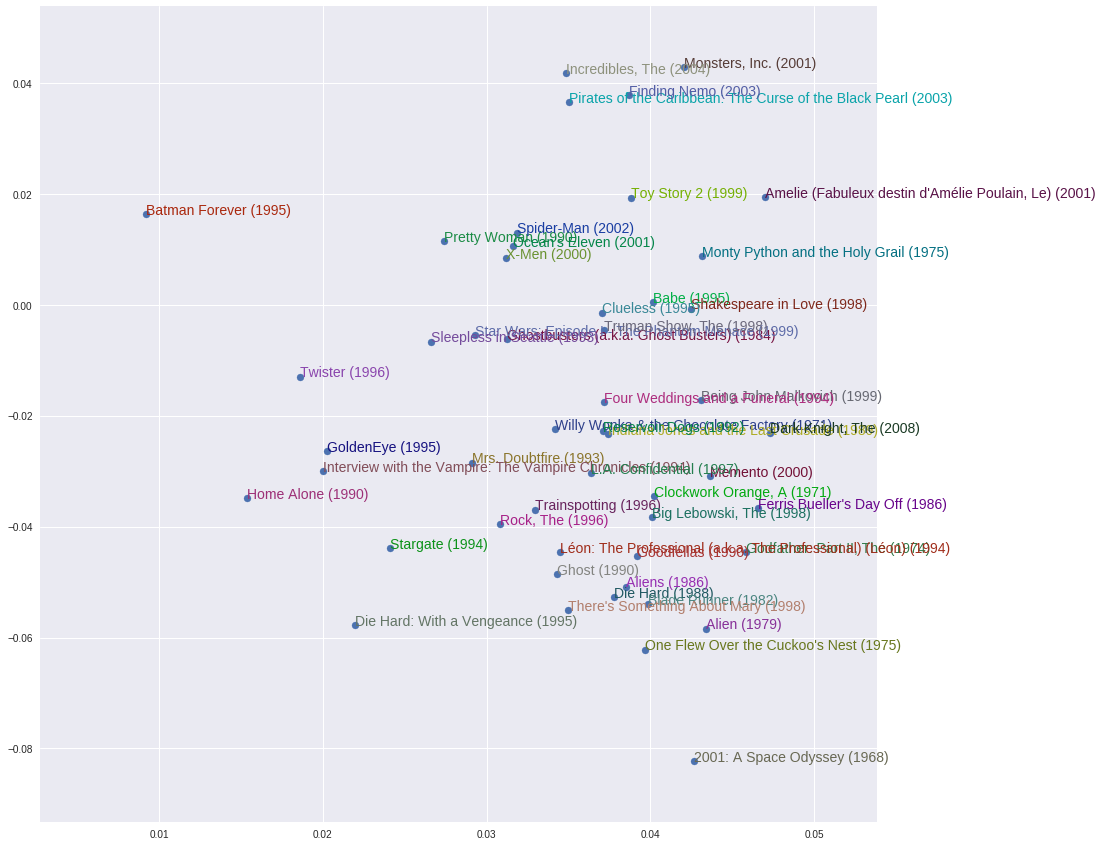

In [198]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [0]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [0]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [201]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80026 samples, validate on 19978 samples
Epoch 1/8
80026/80026 [==============================] - 30s - loss: 2.4206 - val_loss: 0.9218
Epoch 2/8
21056/80026 [======>.......................] - ETA: 25s - loss: 1.4986

80026/80026 [==============================] - 34s - loss: 1.4306 - val_loss: 0.8805
Epoch 3/8
62080/80026 [======================>.......] - ETA: 7s - loss: 1.2311

80026/80026 [==============================] - 31s - loss: 1.2100 - val_loss: 0.8552
Epoch 4/8
80026/80026 [==============================] - 31s - loss: 1.0361 - val_loss: 0.8534
Epoch 5/8
 8384/80026 [==>...........................] - ETA: 27s - loss: 0.9041

80026/80026 [==============================] - 30s - loss: 0.9146 - val_loss: 0.8349
Epoch 6/8
73472/80026 [==========================>...] - ETA: 2s - loss: 0.8521

80026/80026 [==============================] - 30s - loss: 0.8522 - val_loss: 0.8375
Epoch 7/8
80026/80026 [==============================] - 30s - loss: 0.8236 - val_loss: 0.8315
Epoch 8/8
12416/80026 [===>..........................] - ETA: 25s - loss: 0.7814

80026/80026 [==============================] - 31s - loss: 0.8088 - val_loss: 0.8276


This improves on our already impressive accuracy even further!..

Makes one wonder again.. whats the point of the earlier models if we could have gotten straight to the NN model..

possible disadvantages..
- blackbox
- no view of the tripping points .. like in case of randomforests.. etc..